# Marginal Costs

Gets marginal cost values from base network (no-dr) to use as a scenario dimension

In [1]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
NETWORKS = "./../../data/networks/"

In [3]:
n = pypsa.Network(NETWORKS + "er50.nc")

INFO:pypsa.io:Imported network er50.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores


In [131]:
SECTORS = {
    "res": "Residential",
    "com": "Commercial",
    "ind": "Industrial",
    "trn": "Transportation",
}

In [132]:
def get_marginal_cost(n: pypsa.Network) -> pd.DataFrame:
    """Average marginal costs per carrier"""
    return n.buses_t["marginal_price"].rename(columns=n.buses.carrier).T.groupby(level=0).mean().T

def filter_carriers_in_sector(df: pd.DataFrame, sector: str) -> pd.DataFrame:
    """Filters out carriers 
    
    Cant use load buses as transport dr is not attached directly at load
    """
    if sector in ("res", "com"):
        return df[[x for x in df if "-water-" not in x]].copy()
    elif sector in ("trn"):
        return df[["trn-elec-veh", "trn-lpg-veh"]].copy()
    else:
        return df.copy()
    
def assign_nice_names(n: pypsa.Network, df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns=n.carriers.nice_name)

def get_mc_per_sector(n: pypsa.Network, sector: str, nice_name: bool = True) -> pd.DataFrame:
    """Get marginal costs in the sector"""
    assert sector in ("res", "com", "ind", "trn")
    df = get_marginal_cost(n)
    df = df[[x for x in df if sector in x]]
    df = filter_carriers_in_sector(df, sector)
    
    if nice_name:
        return assign_nice_names(n, df)
    else:
        return df
    
def apply_averages(df: pd.DataFrame) -> pd.DataFrame:
    yearly_average = df.mean().mean()
    df["Average"] = df.mean(axis=1)
    df["DR"] = yearly_average
    print(f"Average yearly cost is: {yearly_average}")
    return df

In [133]:
def plot_costs(n: pypsa.Network, sector: str, resample: str = "D", **kwargs) -> tuple:
    
    costs = get_mc_per_sector(n, sector)
    costs = apply_averages(costs)
    
    periods = n.investment_periods
    
    fig, axs = plt.subplots(nrows=len(periods), ncols=1, figsize=(14,4))
    
    for i, period in enumerate(periods):
        
        df = costs.loc[period].resample(resample).mean()
        
        ylabel = "$/MWh"
        title = SECTORS[sector]
        
        if len(periods) < 2:
            df.plot(ax=axs, ylabel=ylabel, title=title, xlabel="", **kwargs)
        else:
            df.plot(ax=axs[i], ylabel=ylabel, title=title, xlabel="", **kwargs)
            pass
            
        i += 1
        
    return fig, axs

Average yearly cost is: 72.16247574049787


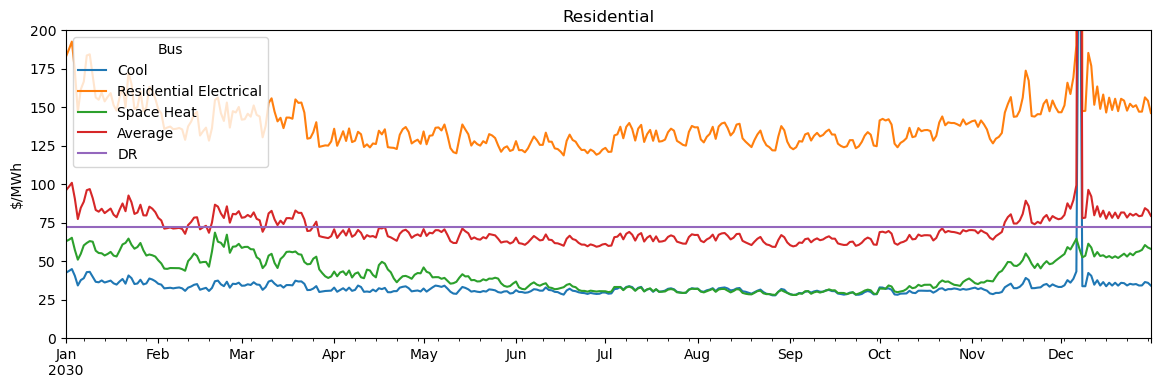

In [134]:
_, _ = plot_costs(n, "res", ylim=(0,200))

Average yearly cost is: 71.93201398530114


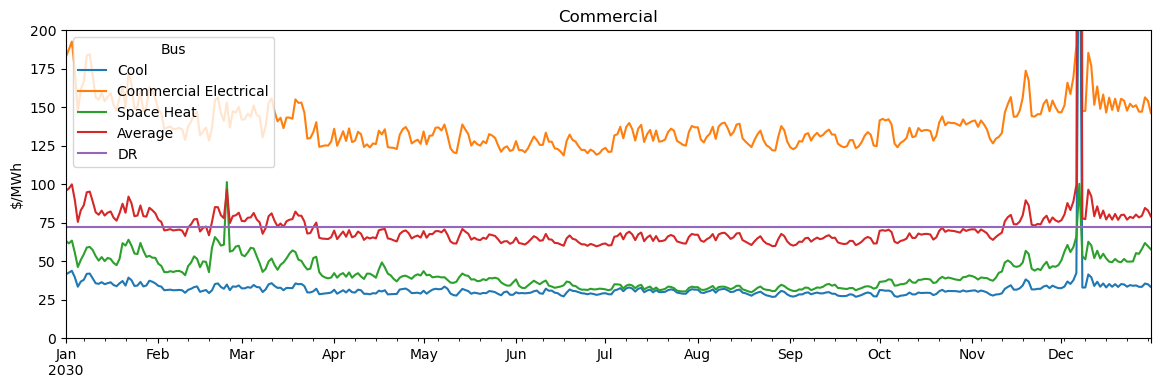

In [135]:
_, _ = plot_costs(n, "com", ylim=(0,200))

Average yearly cost is: 94.7999118507722


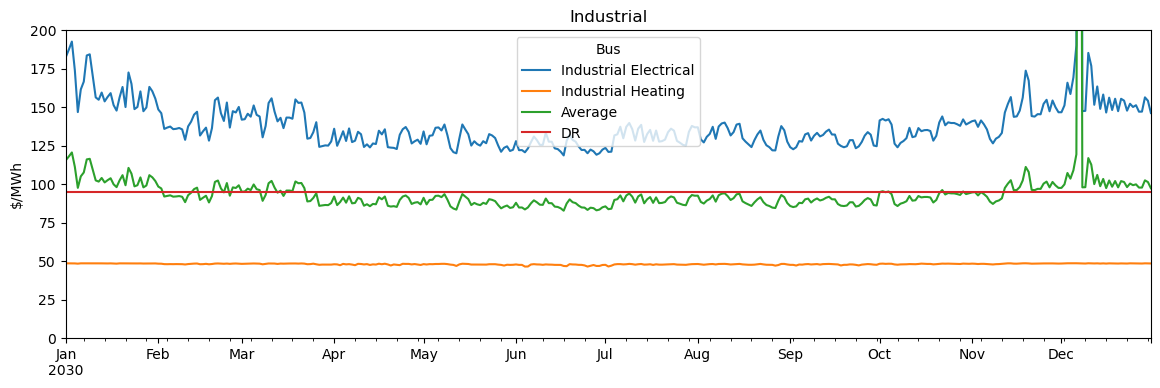

In [136]:
_, _ = plot_costs(n, "ind", ylim=(0,200))

Average yearly cost is: 93.70959182040546


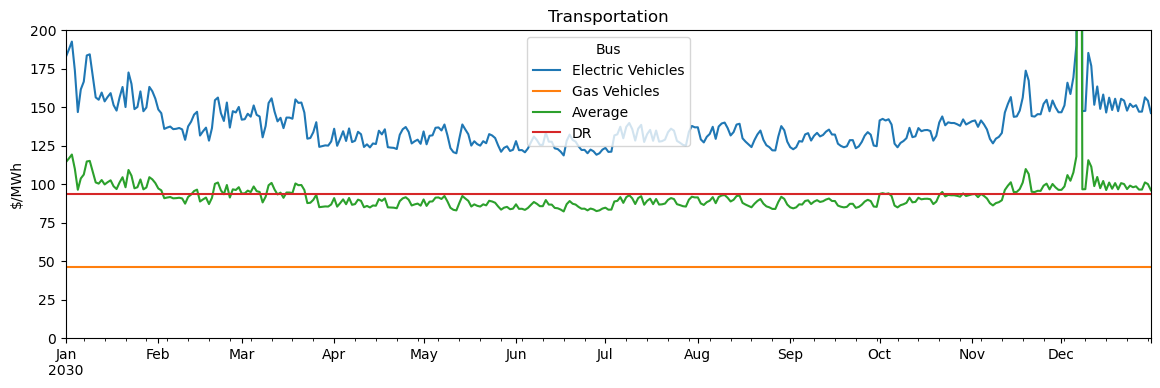

In [137]:
_, _ = plot_costs(n, "trn", ylim=(0,200))